In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# Function to preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        raise FileNotFoundError(f"PNG file {image_path} not found")

    # Normalize and resize
    img = img.astype(np.float32)
    img /= np.max(img)  # Normalize to [0, 1]
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = np.stack([img] * 3, axis=-1)  # Expand dimensions to RGB

    return img

# Function to identify features
def identify_features(image):
    if image.ndim == 3:
        image = np.mean(image, axis=-1)  # Convert to grayscale if it's RGB
    
    coronal_holes = (image < 0.1).astype(np.uint8)  # Dark regions
    solar_flares = (image > 0.4).astype(np.uint8)  # Bright regions
    active_regions = ((image >= 0.3) & (image <= 0.4)).astype(np.uint8)  # Medium brightness
    quiet_regions = ((image >= 0.15) & (image < 0.3)).astype(np.uint8)  # Quiet regions
    
    # Combine into a single mask
    features = np.stack((coronal_holes, solar_flares, active_regions, quiet_regions), axis=-1)
    return features


In [8]:

# Save mask as image file
def save_mask(mask, output_path):
    # Convert mask to a single-channel image by assigning unique values to each feature
    combined_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    combined_mask[mask[:, :, 0] == 1] = 1  # Coronal Holes
    combined_mask[mask[:, :, 1] == 1] = 2  # Solar Flares
    combined_mask[mask[:, :, 2] == 1] = 3  # Active Regions
    combined_mask[mask[:, :, 3] == 1] = 4  # Quiet Regions
    
    success = cv2.imwrite(output_path, combined_mask)
    if not success:
        print(f"Failed to save mask to {output_path}")

# Load the dataset of 100 images and save masks
def load_dataset(image_folder, mask_folder):
    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)
    
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(".png")]
    images = []
    masks = []
    for idx, image_path in enumerate(image_paths):
        try:
            print(f"Processing {image_path}")
            img = preprocess_image(image_path)
            mask = identify_features(img)
            
            images.append(img)
            masks.append(mask)
            
            # Save mask to file
            mask_filename = f"mask_{idx:03d}.png"
            mask_path = os.path.join(mask_folder, mask_filename)
            save_mask(mask, mask_path)
            
            print(f"Saved mask to {mask_path}")
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
    
    print(f"Total images processed: {len(images)}")
    return images, masks


In [9]:
# Define the paths
dataset_folder = 'dataset\Solar_images_final'  # Replace with the path to your 'dataset' folder
mask_folder = os.path.join('dataset\Solar_images_final', 'masks')  # 'masks' folder beside 'dataset' folder

# Load all images and masks
images, masks = load_dataset(dataset_folder, mask_folder)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
C:\Users\dhyan\AppData\Local\Temp\ipykernel_15340\3010693974.py:2: SyntaxWarning: invalid escape sequence '\S'
  dataset_folder = 'dataset\Solar_images_final'  # Replace with the path to your 'dataset' folder
C:\Users\dhyan\AppData\Local\Temp\ipykernel_15340\3010693974.py:3: SyntaxWarning: invalid escape sequence '\S'
  mask_folder = os.path.join('dataset\Solar_images_final', 'masks')  # 'masks' folder beside 'dataset' folder


Processing dataset\Solar_images_final\20210601_000011_1024_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_000.png
Processing dataset\Solar_images_final\20210601_000011_2048_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_001.png
Processing dataset\Solar_images_final\20210602_000010_4096_0171.png
Saved mask to dataset\Solar_images_final\masks\mask_002.png
Processing dataset\Solar_images_final\20210602_000011_1024_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_003.png
Processing dataset\Solar_images_final\20210602_000011_512_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_004.png
Processing dataset\Solar_images_final\20210604_000011_2048_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_005.png
Processing dataset\Solar_images_final\20210610_000011_2048_0211.png
Saved mask to dataset\Solar_images_final\masks\mask_006.png
Processing dataset\Solar_images_final\20210615_000011_512_0211.png
Saved mask to dataset\Solar_images_fin

In [10]:
# Split the dataset
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Convert to NumPy arrays for training
train_images = np.array(train_images)
val_images = np.array(val_images)
train_masks = np.array(train_masks)
val_masks = np.array(val_masks)

In [11]:
# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder (downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck (Bridge)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output Layer
    outputs = layers.Conv2D(4, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize the model
model = unet_model()

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Data Augmentation (for training)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

In [13]:
# Train the model
history = model.fit(
    datagen.flow(train_images, train_masks, batch_size=8),
    steps_per_epoch=len(train_images) // 8,
    validation_data=(val_images, val_masks),
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


9/9 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.3595 - loss: 1.3072 - val_accuracy: 0.5628 - val_loss: 1.2286 - learning_rate: 0.0010
Epoch 2/15
1/9 ━━━━━━━━━━━━━━━━━━━━ 2:03 15s/step - accuracy: 0.4084 - loss: 1.2608

c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4084 - loss: 1.2608 - val_accuracy: 0.5233 - val_loss: 1.2636 - learning_rate: 0.0010
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 16s/step - accuracy: 0.4068 - loss: 1.9615 - val_accuracy: 0.4843 - val_loss: 1.2829 - learning_rate: 0.0010
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4089 - loss: 1.3039 - val_accuracy: 0.4887 - val_loss: 1.2807 - learning_rate: 0.0010
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 144s 16s/step - accuracy: 0.4123 - loss: 1.3490 - val_accuracy: 0.4278 - val_loss: 1.2558 - learning_rate: 0.0010
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4499 - loss: 1.2830 - val_accuracy: 0.4083 - val_loss: 1.2517 - learning_rate: 0.0010
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.4101 - loss: 1.2768 - val_accuracy: 0.4082 - val_loss: 1.2465 - learning_rate: 1.0000e-04
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.4377 - loss: 1.2629 - val_accuracy: 0.4082 - val_lo

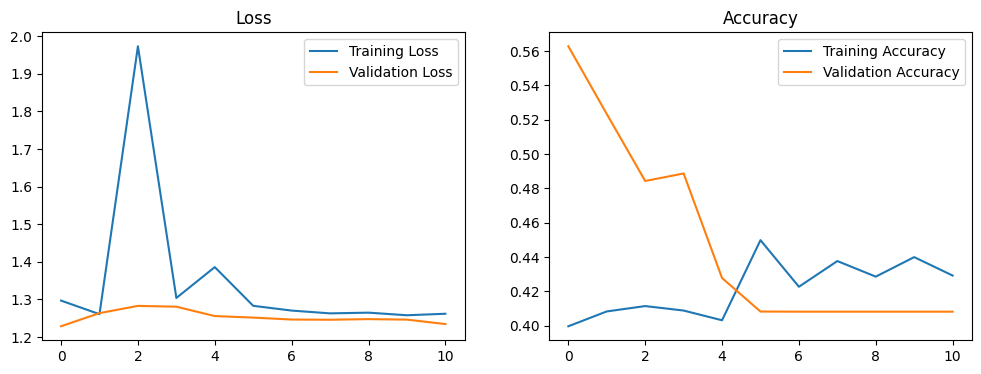

c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(20, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Validation Accuracy: 0.562750244140625
Validation Precision: 0.5558702964759925
Validation Recall: 0.562750244140625
Validation F-score: 0.5422272695874176


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Evaluate the model on the validation set
val_predictions = model.predict(val_images)
val_predictions = np.argmax(val_predictions, axis=-1)

# Convert one-hot encoded masks back to class labels for metrics calculation
val_masks_class = np.argmax(val_masks, axis=-1)

# Calculate metrics
accuracy = accuracy_score(val_masks_class.flatten(), val_predictions.flatten())
precision, recall, fscore, _ = precision_recall_fscore_support(val_masks_class.flatten(), val_predictions.flatten(), average='weighted')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F-score: {fscore}")

In [16]:
# Enhanced visualization and metrics calculation
def calculate_metrics(true_mask, predicted_mask):
    # Flatten the masks
    true_flat = true_mask.flatten()
    pred_flat = predicted_mask.flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(true_flat, pred_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(true_flat, pred_flat, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


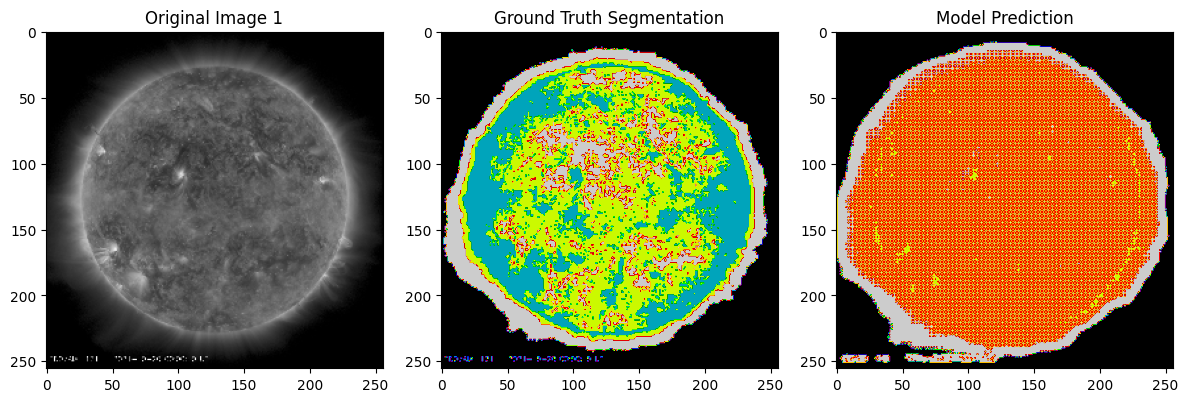


Metrics for Image 1:
Accuracy: 0.521
Precision: 0.521
Recall: 0.521
F1 Score: 0.503

Composition of features in Image 1:
{np.int64(0): '26.7%', np.int64(2): '31.1%', np.int64(3): '42.2%'}


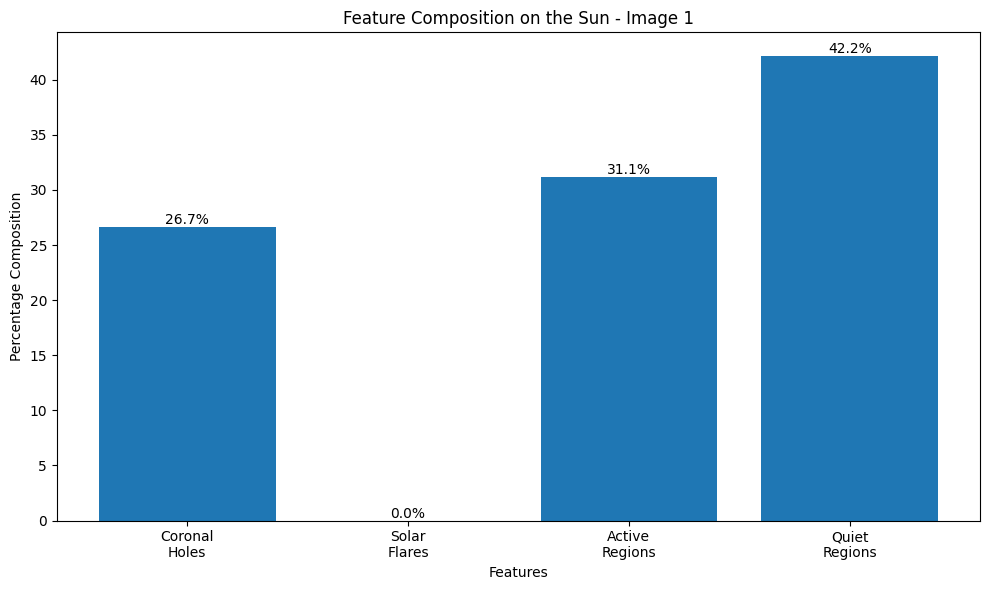

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


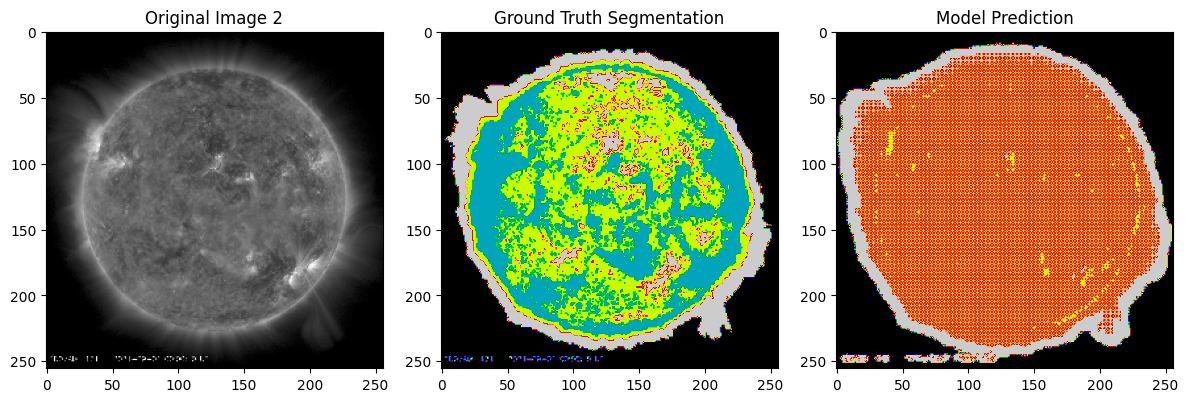


Metrics for Image 2:
Accuracy: 0.500
Precision: 0.501
Recall: 0.500
F1 Score: 0.479

Composition of features in Image 2:
{np.int64(0): '26.8%', np.int64(2): '30.6%', np.int64(3): '42.6%'}


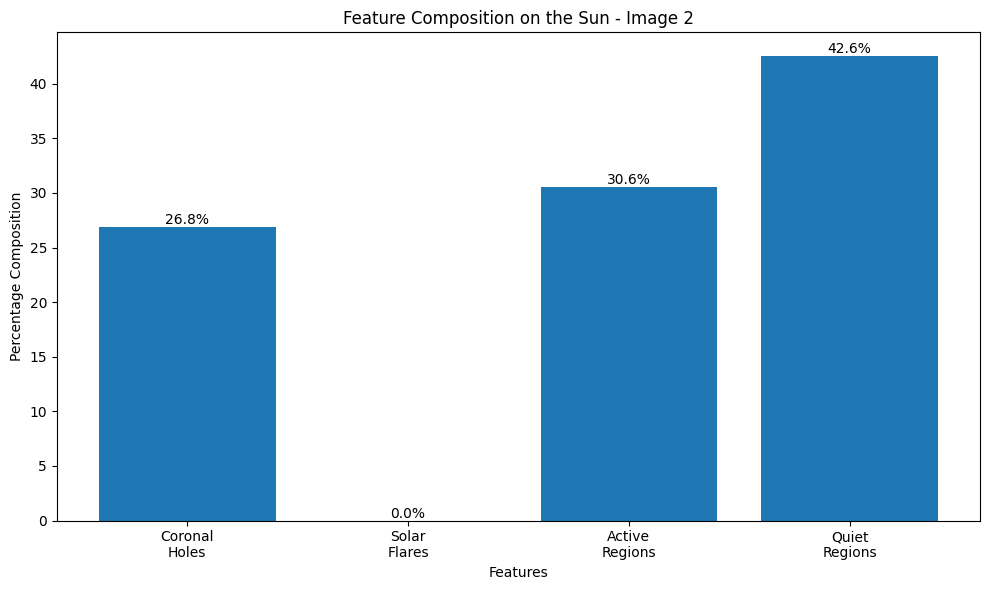

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


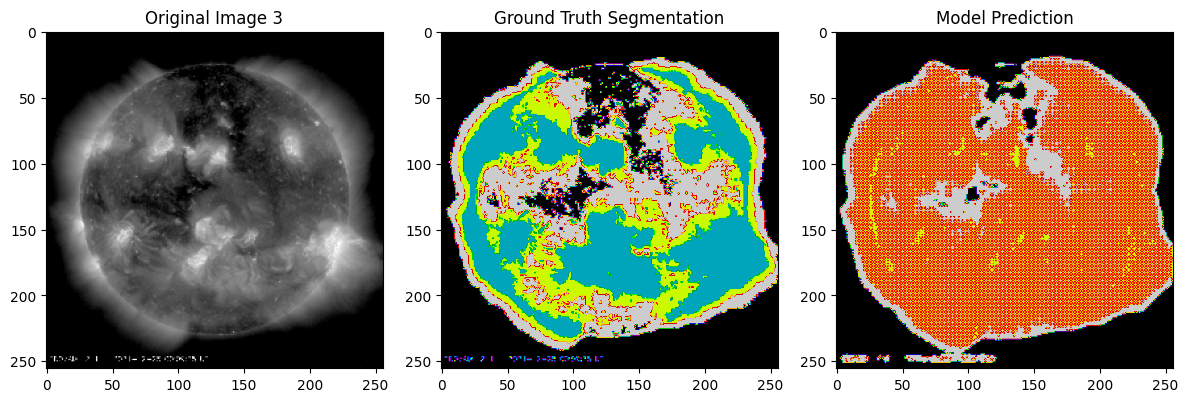


Metrics for Image 3:
Accuracy: 0.535
Precision: 0.505
Recall: 0.535
F1 Score: 0.503

Composition of features in Image 3:
{np.int64(0): '31.4%', np.int64(2): '28.3%', np.int64(3): '40.3%'}


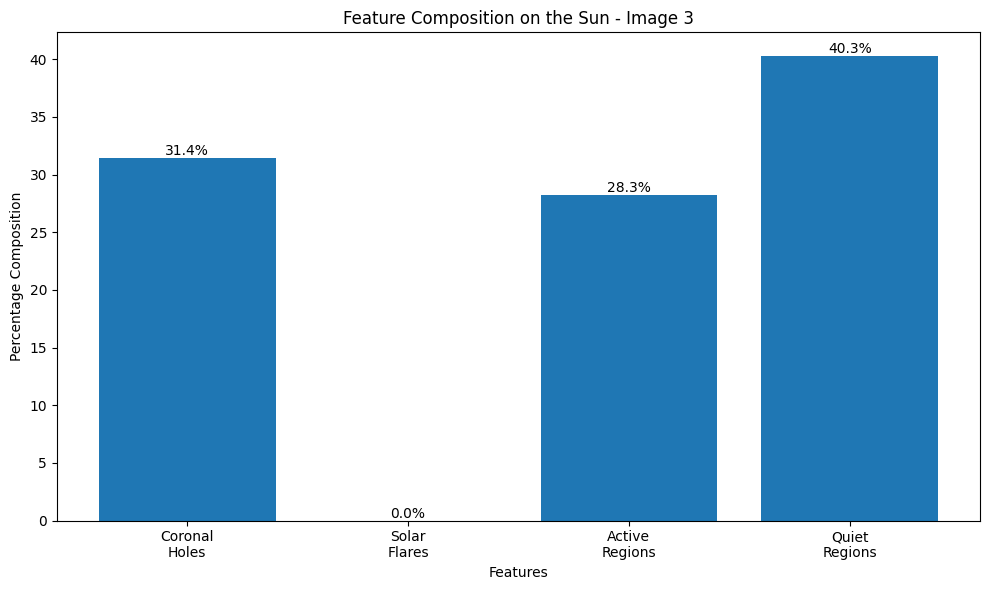


Average Metrics across all test images:
Average Accuracy: 0.519
Average Precision: 0.509
Average Recall: 0.519
Average F1 Score: 0.495


In [17]:
def calculate_feature_composition(segmented_image):
    unique, counts = np.unique(segmented_image, return_counts=True)
    total_pixels = segmented_image.size
    composition = dict(zip(unique, counts / total_pixels * 100))
    return composition

def plot_composition(composition, image_num):
    labels = ['Coronal\nHoles', 'Solar\nFlares', 'Active\nRegions', 'Quiet\nRegions']
    sizes = [composition.get(i, 0) for i in range(4)]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, sizes)
    plt.xlabel('Features')
    plt.ylabel('Percentage Composition')
    plt.title(f'Feature Composition on the Sun - Image {image_num}')
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Post-processing and plotting for 3 test samples
metrics_summary = []

for i in range(3):  # Select 3 sample test images
    # Run the model prediction
    pred_mask = model.predict(np.expand_dims(val_images[i], axis=0))[0]
    pred_mask_classes = np.argmax(pred_mask, axis=-1)
    true_mask_classes = np.argmax(val_masks[i], axis=-1)
    
    # Calculate metrics
    metrics = calculate_metrics(true_mask_classes, pred_mask_classes)
    metrics_summary.append(metrics)
    
    # Plot original and segmented image
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[i])
    plt.title(f'Original Image {i+1}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_classes, cmap='nipy_spectral')
    plt.title('Ground Truth Segmentation')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_classes, cmap='nipy_spectral')
    plt.title('Model Prediction')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for this image
    print(f"\nMetrics for Image {i+1}:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1 Score: {metrics['f1_score']:.3f}")
    
    # Calculate and plot the composition
    composition = calculate_feature_composition(pred_mask_classes)
    print(f"\nComposition of features in Image {i+1}:")
    print({k: f"{v:.1f}%" for k, v in composition.items()})
    plot_composition(composition, i+1)

# Print average metrics across all three images
print("\nAverage Metrics across all test images:")
avg_metrics = {
    metric: np.mean([img_metrics[metric] for img_metrics in metrics_summary])
    for metric in metrics_summary[0].keys()
}
print(f"Average Accuracy: {avg_metrics['accuracy']:.3f}")
print(f"Average Precision: {avg_metrics['precision']:.3f}")
print(f"Average Recall: {avg_metrics['recall']:.3f}")
print(f"Average F1 Score: {avg_metrics['f1_score']:.3f}")